# Meastasis-Analysis
Analysizing the metastatic lungs we scanned from the Ochsenbein group

In [2]:
import platform
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches
import seaborn
import imageio
import pandas
import gc
# import numpy
# import numpy.ma
# import scipy.signal
# import sklearn.cluster
# import skimage.filters
# import skimage.transform
# import skimage.morphology
# import skimage.segmentation
# import skimage.color
# import scipy.ndimage
# import math
# from itkwidgets import view  # 3d viewer
# from tqdm import tqdm_notebook

In [3]:
# Ignore warnings in the notebook
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

In [5]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [6]:
# Display all plots identically
lines = 2
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [7]:
# Different locations if running either on Linux or Windows
FastSSD = True
# to speed things up significantly
if 'debian' in platform.dist():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        BasePath = os.path.join('S:\\')
if FastSSD:
    # We saved the HR datasets into a subfolder
    Root = os.path.join(BasePath, 'Lung-Metastasis', 'HR')
else:
    Root = os.path.join(BasePath, 'Lung-Metastasis')
print('We are loading all the data from %s' % Root)

We are loading all the data from F:\Lung-Metastasis\HR


In [8]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [9]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [10]:
# Get all folders
Data['Folder'] = glob.glob(os.path.join(Root, 'KP*'))

In [11]:
try:
    Data['Folder'][0]
except IndexError:
    print(10 * '\n')
    print('Please mount the Fast SSD!')
    print(10 * '\n')

In [12]:
Data['Sample'] = [os.path.basename(f) for f in Data['Folder']]

In [13]:
Data['LogFile'] = [sorted(glob.glob(os.path.join(f, 'proj', '*.log')))[0] for f in Data['Folder']]
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]

In [14]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f, 'rec', '*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [15]:
# Display some info
for c, row in Data.iterrows():
    print('%02s/%s: %s has %04s reconstructions in %s/%s' % (c +1,
                                                             len(Data), row.Sample,
                                                             row['Number of reconstructions'],
                                                             os.path.basename(row['Folder']),
                                                             'rec'))

 1/11: KP-TNIK--01 has 2977 reconstructions in KP-TNIK--01/rec
 2/11: KP-TNIK--02 has 2967 reconstructions in KP-TNIK--02/rec
 3/11: KP-TNIK--03 has 3148 reconstructions in KP-TNIK--03/rec
 4/11: KP-TNIK--11 has 3071 reconstructions in KP-TNIK--11/rec
 5/11: KP-TNIK--12 has 3064 reconstructions in KP-TNIK--12/rec
 6/11: KP-TNIK--13 has 3064 reconstructions in KP-TNIK--13/rec
 7/11: KP-TNIKWT01 has 2533 reconstructions in KP-TNIKWT01/rec
 8/11: KP-TNIKWT02 has 3132 reconstructions in KP-TNIKWT02/rec
 9/11: KP-TNIKWT03 has 3138 reconstructions in KP-TNIKWT03/rec
10/11: KP-TNIKWT11 has 3113 reconstructions in KP-TNIKWT11/rec
11/11: KP-TNIKWT12 has 3158 reconstructions in KP-TNIKWT12/rec


In [16]:
# Convert all reconstructions into a single numpy array and them to disk
# But only do this if we didn't do it already :)
# Partially based on http://stackoverflow.com/a/39195332/323100
# Since we reload/memorymap the stack below, we overwrite the variable with NaN and clear the memory
Data['OutputNameRec'] = [os.path.join(f, sample + '_rec.npy') for f, sample in zip(Data.Folder, Data.Sample)]
# Don't save into the dataframe, or else we won't be able to make it :)
Reconstructions = [numpy.nan for file in Data['OutputNameRec']]
# Do it now      
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameRec']):
        print('%2s/%s: %s: Already saved to %s' % (c + 1, len(Data), row['Sample'], row['OutputNameRec']))
    else:
        print('%2s/%s: %s: Loading %04s reconstructions' % (c + 1, len(Data), row['Sample'], row['Number of reconstructions']))
        # https://groups.google.com/forum/#!topic/imageio/O3TjIWKzd5Q
        Reconstructions[c] = numpy.stack([imageio.imread(rec,
                                                         ignoregamma=True) for rec in row['Reconstructions']], 0)
        print('%18s: Saving to %s' % (row['Sample'], row['OutputNameRec'][len(Root):]))
        numpy.save(row['OutputNameRec'], Reconstructions[c], allow_pickle=False)        
        # Clear memory
        Reconstructions[c] = numpy.nan
        gc.collect()

 1/11: KP-TNIK--01: Already saved to F:\Lung-Metastasis\HR\KP-TNIK--01\KP-TNIK--01_rec.npy
 2/11: KP-TNIK--02: Already saved to F:\Lung-Metastasis\HR\KP-TNIK--02\KP-TNIK--02_rec.npy
 3/11: KP-TNIK--03: Loading 3148 reconstructions
       KP-TNIK--03: Saving to \KP-TNIK--03\KP-TNIK--03_rec.npy
 4/11: KP-TNIK--11: Already saved to F:\Lung-Metastasis\HR\KP-TNIK--11\KP-TNIK--11_rec.npy
 5/11: KP-TNIK--12: Already saved to F:\Lung-Metastasis\HR\KP-TNIK--12\KP-TNIK--12_rec.npy
 6/11: KP-TNIK--13: Already saved to F:\Lung-Metastasis\HR\KP-TNIK--13\KP-TNIK--13_rec.npy
 7/11: KP-TNIKWT01: Already saved to F:\Lung-Metastasis\HR\KP-TNIKWT01\KP-TNIKWT01_rec.npy
 8/11: KP-TNIKWT02: Already saved to F:\Lung-Metastasis\HR\KP-TNIKWT02\KP-TNIKWT02_rec.npy
 9/11: KP-TNIKWT03: Already saved to F:\Lung-Metastasis\HR\KP-TNIKWT03\KP-TNIKWT03_rec.npy
10/11: KP-TNIKWT11: Already saved to F:\Lung-Metastasis\HR\KP-TNIKWT11\KP-TNIKWT11_rec.npy
11/11: KP-TNIKWT12: Loading 3158 reconstructions
       KP-TNIKWT12: 

In [20]:
# Clear memory
# %xdel Reconstructions
# Load (or memory-map) all the files.
# This is loading the images like a virtual stack in ImageJ
Reconstructions = [numpy.load(file, mmap_mode='r') for file in Data['OutputNameRec'][:1]]

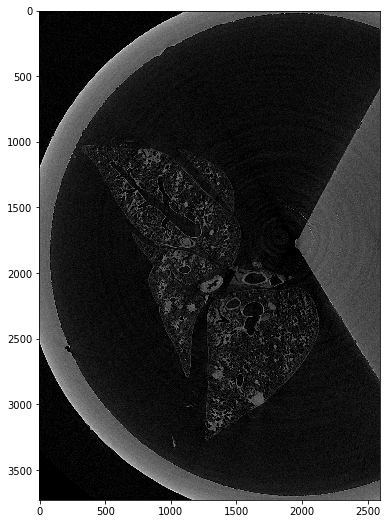

In [22]:
for i in Reconstructions:
    plt.imshow(i[numpy.shape(i)[0]//2,:,:])
    plt.show()

In [ ]:
# How big are the datasets?
Data['Size'] = [numpy.shape(rec) for rec in Reconstructions]

In [ ]:
Data['MiddleImage'] = [imageio.imread(r[n//2], ignoregamma=True) for r, n in zip(Data['Reconstructions'],
                                                                                 Data['Number of reconstructions'])]

In [ ]:
# Save ourselves a middle image
Data['MiddleImage'] = [rec[numpy.shape(i)[0]//2,:,:] for rec in Reconstructions]

In [ ]:
# Try to remove the holder from the reconstruction
# We assume that the holder touches the borders
def remove_holder(image):
    '''Remove the holder from the image by clearing from the border'''
    # Threshold image
    thresholded = image > skimage.filters.threshold_li(image)
    # Get all pixels that touch the border
    borderless = skimage.segmentation.clear_border(thresholded)
    holder = numpy.bitwise_xor(thresholded, borderless)
    dilation = True
    if dilation:
        holder = skimage.morphology.binary_dilation(holder,
                                                    selem=skimage.morphology.disk(7))
    else:
        holder = skimage.morphology.binary_closing(holder,
                                                   selem=skimage.morphology.disk(7))
    imagewithoutholder = numpy.ma.masked_where(holder, image).filled(0)
    return(imagewithoutholder, holder)

In [ ]:
# We could probably save the values in one go, but it also works like that :)
Data['tmp'] = [remove_holder(mi) for mi in Data['MiddleImage']]
Data['Holderless'] = [t[0] for t in Data['tmp']]
Data['Holder'] = [t[1] for t in Data['tmp']]
Data.drop('tmp', axis=1, inplace=True)

In [ ]:
# Calculate threshold for segmentation
Data['Threshold'] = [skimage.filters.threshold_otsu(hl[hl>0]) for hl in Data['Holderless']]

In [ ]:
# Threshold the images
Data['Thresholded'] = [mi>t for mi, t in zip(Data['Holderless'],
                                             Data['Threshold'])]

In [ ]:
# How does it look like?
for c, row in Data.iterrows():
    plt.subplot(141)
    plt.imshow(row.MiddleImage)
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
    recname = os.path.basename(row['Reconstructions'][row['Number of reconstructions']//2]).replace('0000', '')
    plt.title('%s/%s: %s' % (c+1, len(Data), recname))
    plt.axis('off')
    plt.subplot(142)
    fill = 30
    plt.imshow(numpy.ma.masked_less(row['Holderless'], fill).filled(0))
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
    plt.axis('off')
    plt.title('Without holder, everything <%s masked' % fill)
    plt.subplot(143)
    plt.hist(row.Holderless[row.Holderless>0].ravel(),
             log=True,
             bins=32)
    plt.axvline(row.Threshold, c='r')
    plt.xlim([0, 255])
    plt.title('Histogram of holderless image\nOtsu-Threshold at %s' % row.Threshold)
    plt.subplot(144)
    plt.imshow(row.Thresholded)
    plt.axis('off')
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))    
    plt.title('Thresholded image')
    plt.show()

In [ ]:
# Plot thresholds
seaborn.boxplot(Data['Threshold'])
seaborn.stripplot(Data['Threshold'], jitter=True, s=15, linewidth=1.5, color='gray')
for c, i in Data.iterrows():
    plt.text(i.Threshold,
            (0.5 * numpy.random.random_sample()) - 0.25,
             '%s: %0.2f' % (i.Sample,
                          i.Threshold),
             ha='center')
plt.show()

In [ ]:
for c, row in Data.iterrows():
    plt.subplot(141)
    plt.imshow(row['MiddleImage'])
    plt.axis('off')
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
    plt.title('%s, original slice' % row['Sample'])    
    plt.subplot(142)
    plt.imshow(row['Holderless'])
    plt.axis('off')
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
    plt.title('Holder removed')
    plt.subplot(143)
    plt.imshow(row['Thresholded'])
    plt.title('Thresholded with %0.2f' % row['Threshold'])
    plt.axis('off')
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
    plt.subplot(144)
    plt.imshow(row['MiddleImage'][500:1000,:500])
    plt.imshow(row['Holder'][500:1000,:500],
               cmap='viridis', alpha=0.5)
    plt.axis('off')
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))    
    plt.title('Detail (Original with detected holder overlay)')
    plt.show()

In [ ]:
# Show all middle images with holders overlay
for c, row in Data.iterrows():
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(row['Holder'], cmap='viridis', alpha=0.5)
    plt.imshow(row['Holderless'], alpha=0.5)
    plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
    recname = os.path.basename(row['Reconstructions'][row['Number of reconstructions']//2]).replace('0000', '').replace('KP-TNIK', '')
    plt.title('%s > %0.1f' % (recname, row['Threshold']))
    plt.axis('off')
plt.show()

In [ ]:
# Perform labeling
# Based on http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html

whichone = 2
size = 1000

image = Data['Holderless'][whichone]
# Erode image a bit, so split touching features
bw = skimage.morphology.binary_erosion(Data['Thresholded'][whichone],
                                       selem=skimage.morphology.disk(3))
# Label now
label_image = skimage.measure.label(bw)
image_label_overlay = skimage.color.label2rgb(label_image,
                                              image=image)

In [ ]:
# Show detected regions
# Show full
plt.imshow(image_label_overlay)
for region in skimage.measure.regionprops(label_image):
    # take regions with large enough areas
    if region.area >= size:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = matplotlib.patches.Rectangle((minc, minr),
                                            maxc - minc,
                                            maxr - minr,
                                            fill=False,
                                            edgecolor='red',
                                            linewidth=2)
        plt.gca().add_patch(rect)
plt.title('%s\nLabel-image with detected regions (>%s px)' % (Data.Sample[whichone],
                                                              size))
plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
plt.axis('off')
os.makedirs(os.path.join(Data.Folder[whichone], 'Output'), exist_ok=True)
plt.savefig(os.path.join(Data.Folder[whichone], 'Output',  Data.Sample[whichone] + '.detection.png'),
            bbox_inches='tight')
plt.show()

In [ ]:
# Show detail/crop
# Set maximal extent (needed for crop)
xmin = numpy.inf
xmax = 0
ymin = numpy.inf
ymax = 0
plt.imshow(image)
plt.imshow(bw, cmap='viridis', alpha=0.309)
for region in skimage.measure.regionprops(label_image, intensity_image=image):
    # take regions with large enough areas
    if region.area >= size:
        if region.eccentricity < 0.5:
            color='green'
        else:
            color='red'        
        # Draw rectangle around segmented coins
        # Collect coordinates on the way
        minr, minc, maxr, maxc = region.bbox
        xmin = numpy.minimum(xmin, minc)
        xmax = numpy.maximum(xmax, maxc)
        ymin = numpy.minimum(ymin, minr)
        ymax = numpy.maximum(ymax, maxr)
        rect = matplotlib.patches.Rectangle((minc, minr),
                                            maxc - minc,
                                            maxr - minr,
                                            fill=False,
                                            edgecolor=color)
        plt.gca().add_patch(rect)
        # Draw centroid and orientation
        plt.scatter(region.centroid[1],
                    region.centroid[0],
                    facecolors='none',
                    s=100,
                    linewidths=2.5,
                    color=color)
        y0, x0 = region.centroid
        orientation = region.orientation
        x1 = x0 + math.cos(orientation) * 0.5 * region.major_axis_length
        y1 = y0 - math.sin(orientation) * 0.5 * region.major_axis_length
        x2 = x0 - math.sin(orientation) * 0.5 * region.minor_axis_length
        y2 = y0 - math.cos(orientation) * 0.5 * region.minor_axis_length
        plt.gca().plot((x0, x1), (y0, y1), color=color, linewidth=2.5)
        plt.gca().plot((x0, x2), (y0, y2), color=color, linewidth=2.5)
        # Draw label
        drawlabel=False
        if drawlabel:
            plt.text(maxc, maxr, region.label, color='white', horizontalalignment='center')
plt.title('%s\nLabel-image with detected regions (>%s px)' % (Data.Sample[whichone],
                                                              size))
plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
plt.axis('off')
plt.savefig(os.path.join(Data.Folder[whichone], 'Output', Data.Sample[whichone] + '.labels.png'),
            bbox_inches='tight')
plt.title('%s\nCropped Label-image with detected regions (>%s px)' % (Data.Sample[whichone],
                                                                      size))
# Set to minmal extent
plt.xlim([xmin-50,xmax+50])
plt.ylim([ymax+50,ymin-50])
plt.savefig(os.path.join(Data.Folder[whichone], 'Output', Data.Sample[whichone] + '.labels.crop.png'),
            bbox_inches='tight')
plt.show()

In [ ]:
# Show the detected regions for themselves
for region in skimage.measure.regionprops(label_image, intensity_image=image):
    # take regions with large enough areas
    if region.area >= size:
        if region.eccentricity < 0.5:
            color='green'
            shape='round'
        else:
            color='red'
            shape='elongated'
        plt.imshow(region.intensity_image)
        plt.imshow(region.image,
                   cmap='viridis',
                   alpha=0.3)
        plt.imshow(region.convex_image,
                   cmap='magma',
                   alpha=0.5)
        plt.scatter(region.local_centroid[1],
                    region.local_centroid[0],
                    facecolors='none',
                    s=500,
                    linewidths=2.5,
                    color=color)
        # http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_regionprops.html#sphx-glr-auto-examples-segmentation-plot-regionprops-py
        y0, x0 = region.local_centroid
        orientation = region.orientation
        x1 = x0 + math.cos(orientation) * 0.309 * region.major_axis_length
        y1 = y0 - math.sin(orientation) * 0.309 * region.major_axis_length
        x2 = x0 - math.sin(orientation) * 0.309 * region.minor_axis_length
        y2 = y0 - math.cos(orientation) * 0.309 * region.minor_axis_length

        plt.gca().plot((x0, x1), (y0, y1), color=color, linewidth=2.5)
        plt.gca().plot((x0, x2), (y0, y2), color=color, linewidth=2.5)
        
        plt.title('Label #%s | area=%s px | generally %s (ecc=%0.2f)' % (region.label,
                                                                         region.area,
                                                                         shape,
                                                                         region.eccentricity))
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))                
        plt.axis('off')
        plt.savefig(os.path.join(Data.Folder[whichone],
                                 'Output',
                                 Data.Sample[whichone] + '.region.%s.png' % str(region.label).zfill(4)),
                    bbox_inches='tight')
        plt.show()

In [ ]:
# Find maxima (or minima when negated :))
x = numpy.random.rand(100)
plt.plot(x)
indices = scipy.signal.find_peaks(numpy.negative(x))[0]
for i in indices:
    plt.plot(i,x[i], c='r', marker='o', mfc='none')

In [ ]:
a = plt.hist(row.MiddleImage.ravel(), bins='auto')

In [ ]:
plt.plot(a[0][::4])